# 导包

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#直接在python console里面生成图像
%matplotlib inline 
import numpy as np
import sklearn
import pandas as pd
from tensorflow import keras


for module in mpl, np, sklearn, pd:
    print(module.__name__, module.__version__)

matplotlib 3.2.2
numpy 1.19.5
sklearn 0.23.1
pandas 1.0.5


# 获取数据集

In [7]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [8]:
#换一种数据打印方式
import pprint
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


# 数据预处理

# （1）数据划分

In [9]:
"""

train_test_split()函数是用来随机划分样本数据为训练集和测试集的，当然也可以人为的切片划分。

优点：随机客观的划分数据，减少人为因素

完整模板：

train_X,test_X,train_y,test_y = train_test_split(train_data,train_target,test_size=0.3,random_state=5)

参数解释：

train_data：待划分样本数据

train_target：待划分样本数据的结果（标签）

test_size：测试数据占样本数据的比例，若整数则样本数量

random_state：设置随机数种子，保证每次都是同一个随机数。若为0或不填，则每次得到数据都不一样

"""

from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


# （2）数据归一化处理

In [10]:
from sklearn.preprocessing import StandardScaler

# 标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导  
scaler=StandardScaler()

"""

transform函数是一定可以替换为fit_transform函数的，fit_transform函数不能替换为transform函数！
fit_transform()先拟合数据，再标准化  
transform()数据标准化

"""

x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled  = scaler.transform(x_test)

"""
在训练集上调用fit_transform()，其实找到了均值μ和方差σ^2，即我们已经找到了转换规则，
我们把这个规则利用在训练集上，同样，我们可以直接将其运用到测试集上（甚至交叉验证集），
所以在测试集上的处理，我们只需要标准化数据而不需要再次拟合数据

即一次fit_transform，多次transform。

"""


# 构建模型

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                       input_shape=x_train.shape[1:]),
    keras.layers.Dense(1),
])

model.compile(loss="mean_squared_error", optimizer="sgd")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


# 查看模型中的层数

In [14]:
model.layers

# 输出模型各层的参数状况

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


# 定义回调函数

In [19]:
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

# 模型训练

In [20]:
history = model.fit(x_train_scaled, y_train,
                     validation_data = (x_valid_scaled, y_valid),
                     epochs = 100,
                    callbacks = callbacks
                   )

Epoch 1/100
363/363 [==============================] - 4s 3ms/step - loss: 1.4136 - val_loss: 0.6233
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.5406 - val_loss: 0.5268
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4971 - val_loss: 0.5025
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4556 - val_loss: 0.5557
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4415 - val_loss: 0.4389
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4089 - val_loss: 0.4311
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4028 - val_loss: 0.4197
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3972 - val_loss: 0.4153
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3880 - val_loss: 0.4121
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3776 - val_lo

# history中的一个变量，其中包含一些值

In [21]:
history.history

{'loss': [0.8632075786590576,
  0.5363500118255615,
  0.49669119715690613,
  0.4485248029232025,
  0.43020644783973694,
  0.4132368266582489,
  0.4070609509944916,
  0.3976878821849823,
  0.3911682963371277,
  0.3853471875190735,
  0.3808273673057556,
  0.37864023447036743,
  0.38333484530448914,
  0.37331584095954895,
  0.36974960565567017,
  0.37044206261634827,
  0.37571442127227783,
  0.3681437373161316,
  0.38591858744621277,
  0.3662325143814087,
  0.35985830426216125,
  0.3577727675437927,
  0.3559771776199341],
 'val_loss': [0.6232901215553284,
  0.5267685055732727,
  0.5024823546409607,
  0.5556734800338745,
  0.43892285227775574,
  0.4310579299926758,
  0.41965991258621216,
  0.415304571390152,
  0.4120640754699707,
  0.40032127499580383,
  0.40154874324798584,
  0.4000304937362671,
  0.3881605267524719,
  0.38438355922698975,
  0.3849121332168579,
  0.3804555833339691,
  0.3808414340019226,
  0.37457671761512756,
  0.37804263830184937,
  0.375925213098526,
  0.37196823954582

# 可视化（打印出指标的变化过程）

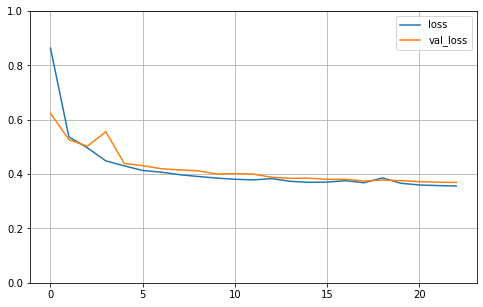

In [23]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)
    

# 测试

In [28]:

"""

evaluate 中的 verbose

verbose：日志显示
verbose = 0 为不在标准输出流输出日志信息
verbose = 1 为输出进度条记录
注意： 只能取 0 和 1；默认为 1
"""
model.evaluate(x_test_scaled, y_test, verbose=1)

162/162 [==============================] - 0s 764us/step - loss: 0.3758


0.37575313448905945